In [4]:
options(warn=-1)

library(magrittr)
library(mixtools)
library(RCurl)
library(stringr)
library(pheatmap)
library(readr)
library(ggplot2)
library(CoRe)
library(qusage)


data('curated_BAGEL_essential')
data('curated_BAGEL_nonEssential')

## CERES integrated dependency dataset (release 1 Sanger, version 20Q2 Broad).
## downloaded from: https://www.depmap.org/broad-sanger/integrated_Sanger_Broad_essentiality_matrices_20201201.zip
## scaled using CERES with the above curated BAGEL gene sets
## dependency profile containing NAs were removed
## cell line names were annotated using the cell line annotation from the cell model passports
load('data/CERES_scaled_depFC.RData')

## The dataset was binarized by considering all genes with FC score < -0.5 = 1, else 0
load('data/CERES_binary.RData')

## Essentials genes obtained with CENtools using BAGEL curated genes as reference sets (default nº bin = 20)
load('data/CENtools_Essentials.RData')

## download cell line annotation from the Cell Model Passports
clannotation <- CoRe.download_AnnotationModel()

## determining tissues with at least 15 cell lines in the dependency matrix
tissues_ctypes<-
  names(which(summary(as.factor(clannotation$tissue[match(colnames(bdep),clannotation$model_name)]))>=15))

print('ADaM will be executed at the tissue type level on the following tissue lineages:')
print(tissues_ctypes)  


── Column specification ─────────────────────────────────────────────────────────────────────────────────
cols(
  .default = col_character(),
  pmed = col_double(),
  mutational_burden = col_double(),
  ploidy = col_double(),
  mutation_data = col_logical(),
  methylation_data = col_logical(),
  expression_data = col_logical(),
  cnv_data = col_logical(),
  crispr_ko_data = col_logical(),
  fusion_data = col_logical(),
  drug_data = col_logical(),
  rnaseq_data = col_logical(),
  age_at_sampling = col_double(),
  sampling_day = col_double(),
  sampling_month = col_double(),
  sampling_year = col_double()
)
ℹ Use `spec()` for the full column specifications.




[1] "ADaM will be executed at the tissue type level on the following tissue lineages:"
 [1] "Biliary Tract"               "Bladder"                    
 [3] "Bone"                        "Breast"                     
 [5] "Central Nervous System"      "Endometrium"                
 [7] "Esophagus"                   "Haematopoietic and Lymphoid"
 [9] "Head and Neck"               "Kidney"                     
[11] "Large Intestine"             "Liver"                      
[13] "Lung"                        "Ovary"                      
[15] "Pancreas"                    "Peripheral Nervous System"  
[17] "Skin"                        "Soft Tissue"                
[19] "Stomach"                    


[1] "Running ADaM for Biliary Tract"
[1] "- Profiling of number of fitness genes across fixed numbers of cell lines and its cumulative sums"
[1] "+ Done!"
[1] "- Null modeling numbers of fitness genes across numbers of cell lines and their cumulative sums"
[1] "Generating null model..."
  |======================================================================| 100%
[1] ""
[1] "Done"
[1] "+ Done!"
[1] "- Computing empirical odds of numbers of fitness genes per number of cell lines"
[1] "+ Done"
[1] "- Profiling true positive rates"
[1] "- Done!"
[1] "+ Calculating ADaM threshold (min. n. of dependent cell lines for core fitness genes)"
[1] "ADaM threshold = 16 (out of 19 cell lines)"
[1] "- Done!"
[1] "+ Estimating set of core fitness genes"
[1] "- Done!"
[1] "Running ADaM for Bladder"
[1] "- Profiling of number of fitness genes across fixed numbers of cell lines and its cumulative sums"
[1] "+ Done!"
[1] "- Null modeling numbers of fitness genes across numbers of cell lines and their c

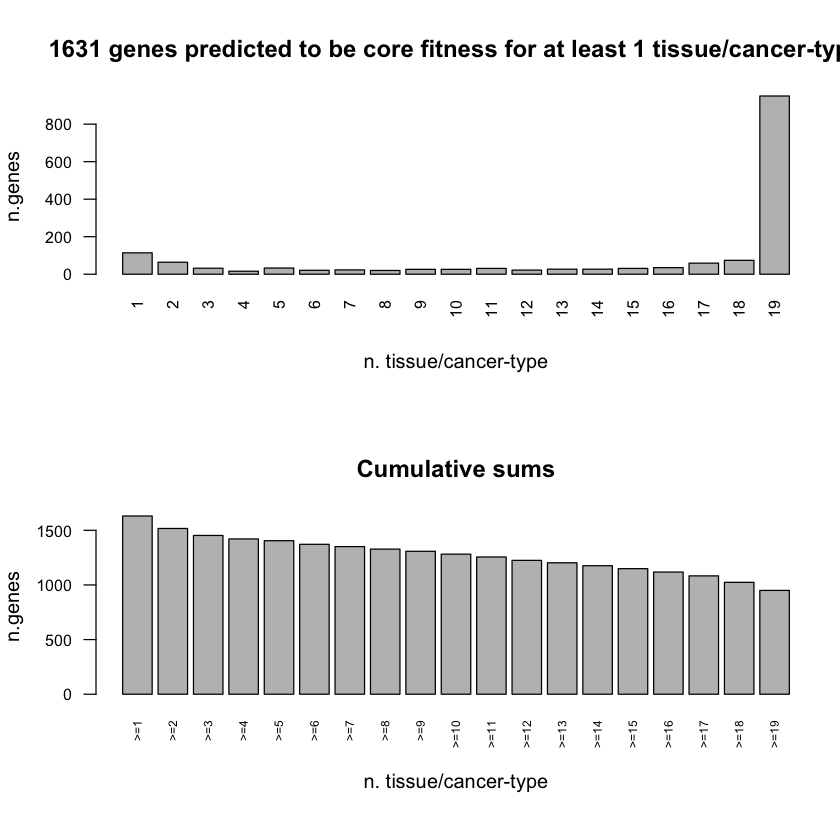

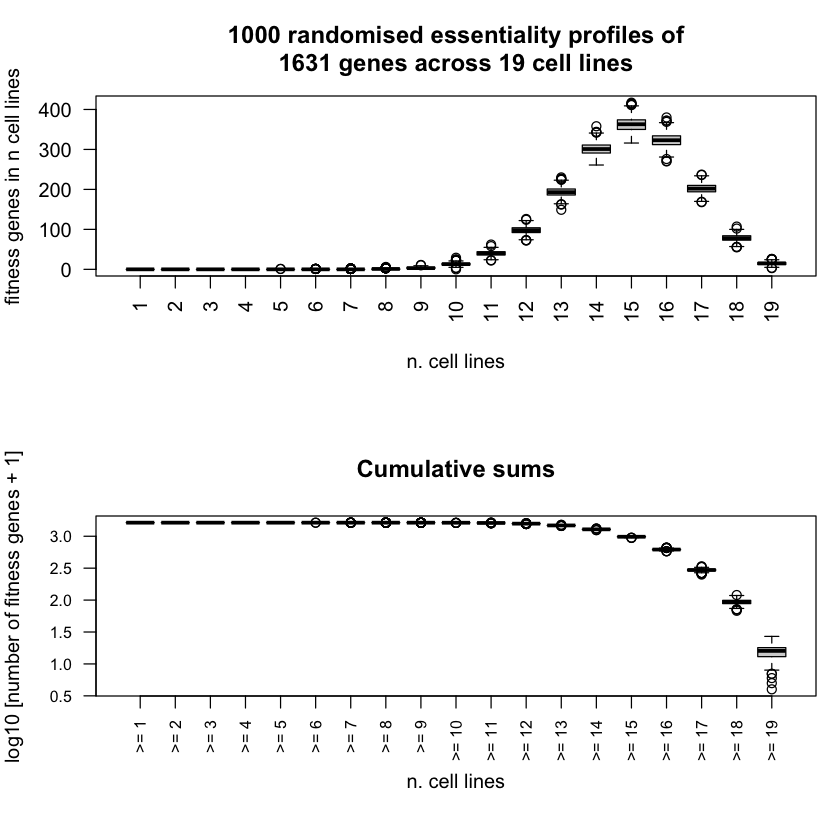

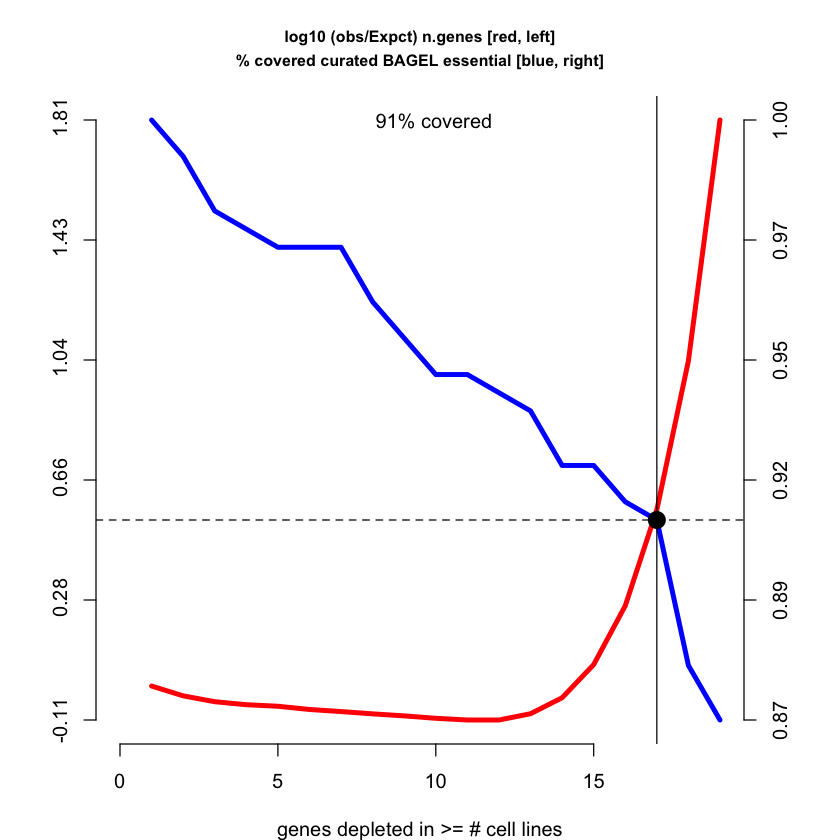

In [6]:
## compute pancancer core fitness genes
ADaM <- CoRe.PanCancer_ADaM(bdep,
                            tissues_ctypes,
                            clannotation = clannotation,
                            display=FALSE,
                            ntrials=100,
                            verbose=TRUE,
                            TruePositives = curated_BAGEL_essential)

## 90-th percentile with fixed strategy
Perc_fixed <- CoRe.PercentileCF(scaled_depFC,
                                display=FALSE,
                                method = 'fixed')$cfgenes

## 90-th percentile with avg strategy
Perc_avg <- CoRe.PercentileCF(scaled_depFC,
                              display=FALSE,
                              method = 'average')$cfgenes

## 90-th percentile with slope strategy
Perc_slope <- CoRe.PercentileCF(scaled_depFC,
                                display=FALSE,
                                method = 'slope')$cfgenes

## 90-th percentile with AUC strategy
Perc_AUC <- CoRe.PercentileCF(scaled_depFC,
                              display=FALSE,
                              method = 'AUC')$cfgenes

Perc_Consensus<-Reduce(intersect,list(Perc_fixed,Perc_avg,Perc_slope,Perc_AUC))

Perc_Last3_Consensus<-Reduce(intersect,list(Perc_fixed,Perc_slope,Perc_AUC))


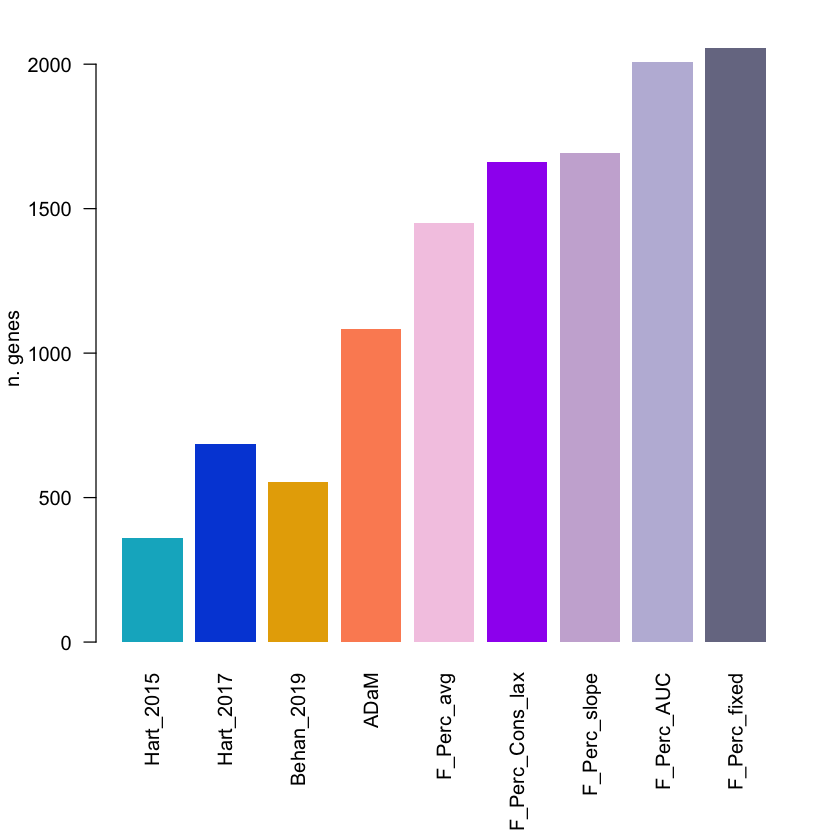

In [7]:
## CENtools
CENtools_SV1_B20Q2_CERES <- CENtools_ess

## CENtools Sharma et al, 2020
CENtools_2020<-read.table(file = 'data/CenTools_essential_Sharma_et_al.txt',sep='\t',stringsAsFactors = FALSE)$V1

## ADaM essential Behan et al, 2019
load('data/ADaM_CFs_Behan_et_Al_2019.RData')
ADaM_2019<-PanCancerCoreFitnessGenes

data(BAGEL_essential)
Hart_Essential_2015<-BAGEL_essential

load('data/BAGEL_v2_ESSENTIAL_GENES.rdata')
Hart_Essential_2017<-BAGEL_essential

##### Barplot comparing n. of predicted CF genes
CFs_sets<-list(Hart_2015=Hart_Essential_2015,
               Hart_2017=Hart_Essential_2017,
               Behan_2019=ADaM_2019,
               ADaM = ADaM,
               F_Perc_avg = Perc_avg,
               F_Perc_Cons_lax = Perc_Last3_Consensus,
               F_Perc_slope = Perc_slope,
               F_Perc_AUC = Perc_AUC,
               F_Perc_fixed = Perc_fixed)

col=c("#03B2C8","#034DD9","#E6AB02","#1B9E77","#337100","#FC8D62",'black',
      "#F4CAE4",'purple',"#CAB2D6","#BEBADA","#777892")
names(col)<-c("Hart_2015","Hart_2017","Behan_2019","Sharma_2020","CENtools","ADaM",
              "F_Perc_Cons","F_Perc_avg","F_Perc_Cons_lax","F_Perc_slope","F_Perc_AUC","F_Perc_fixed")

par(mar=c(8,4,2,2))
barplot(unlist(lapply(CFs_sets,length)),ylab='n. genes',las=2,border = FALSE,col=col[names(CFs_sets)])

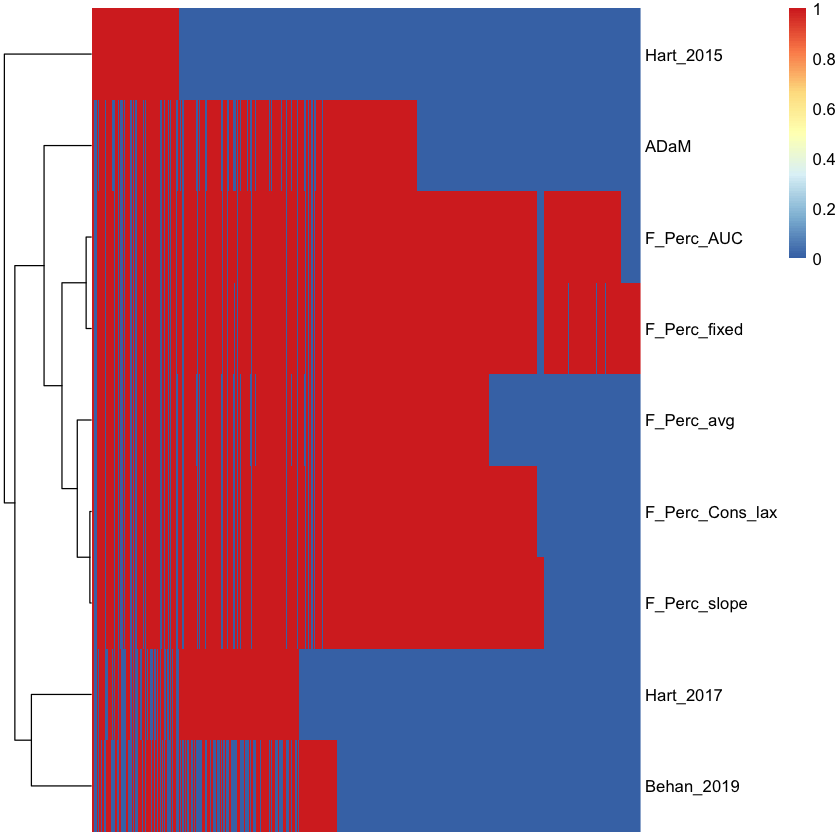

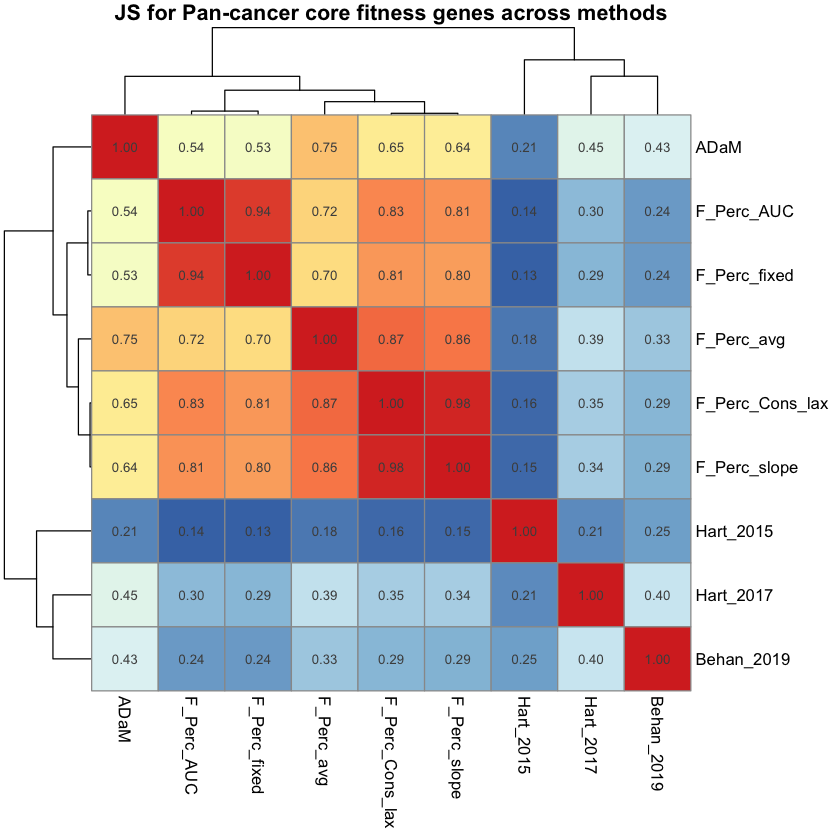

In [8]:
##### CF gene set similarity
allEss<-unique(unlist(CFs_sets))
membMat<-do.call(rbind,lapply(CFs_sets,function(x){is.element(allEss,x)}))
rownames(membMat)<-names(CFs_sets)
colnames(membMat)<-allEss
membMat<-membMat+0

pheatmap(membMat,show_colnames = FALSE,clustering_distance_rows = 'binary',cluster_cols = FALSE,border_color = NA)

dmat<-dist(membMat,method = 'binary')

pheatmap(1-as.matrix(dmat), main = 'JS for Pan-cancer core fitness genes across methods', 
         legend = FALSE,display_numbers = round(dmat,digits = 2))

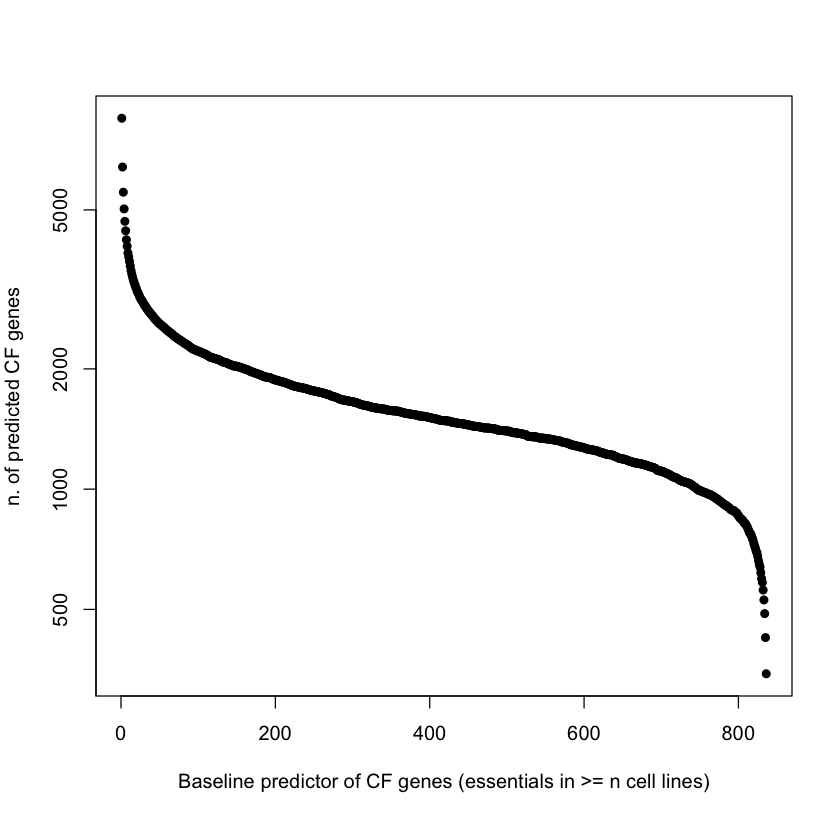

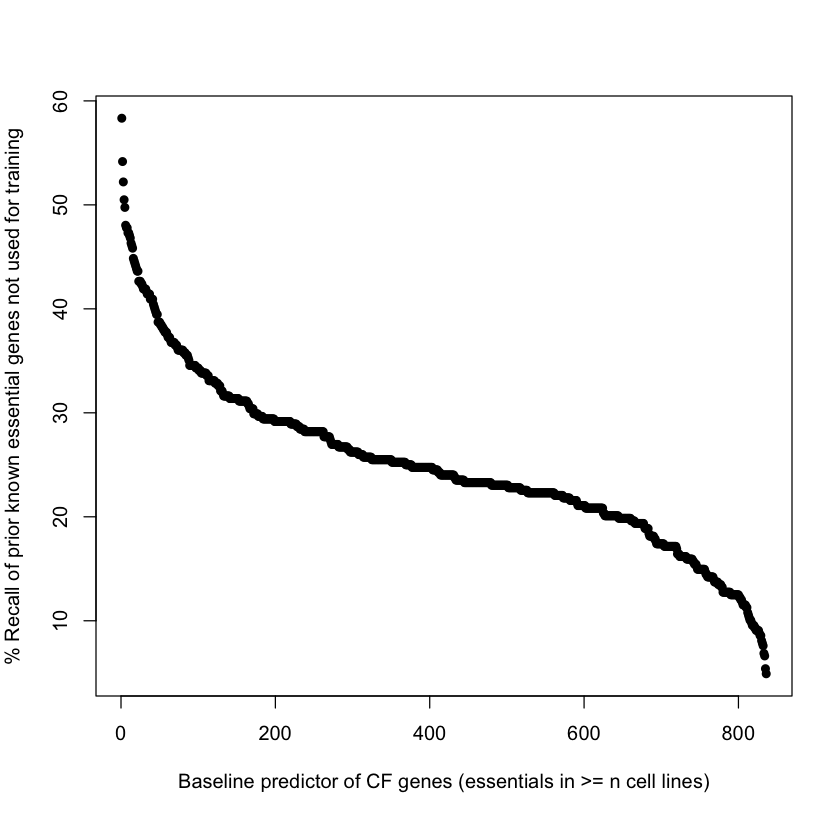

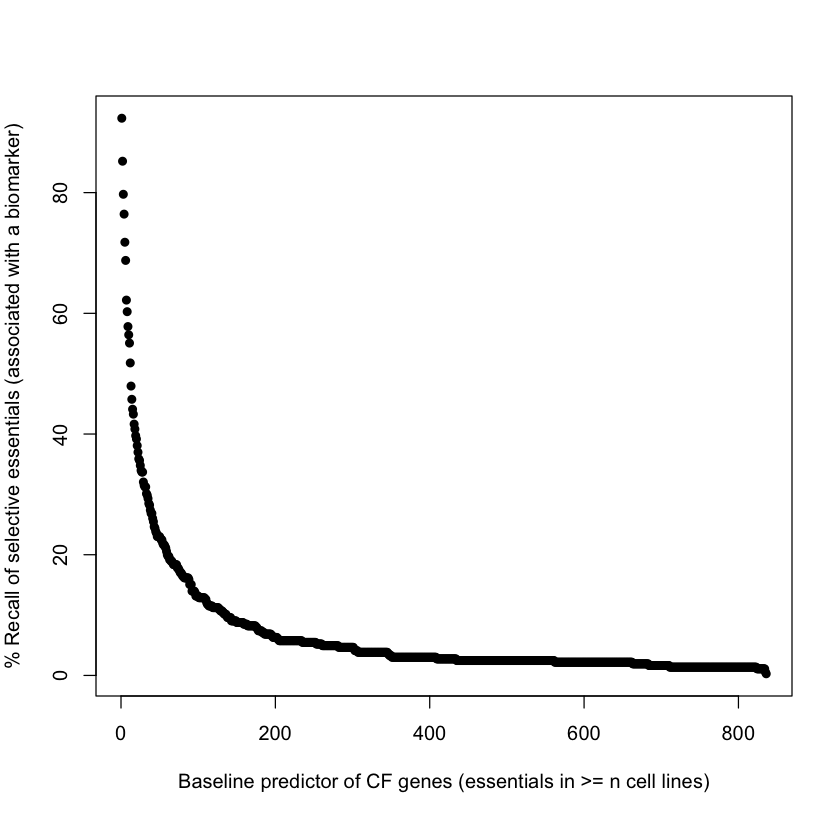

In [11]:
##### Ability to identify novel hits
CFs_sets<-list(Behan_2019=ADaM_2019,
               Sharma_2020=CENtools_2020,
               CENtools = CENtools_SV1_B20Q2_CERES,
               ADaM = ADaM,
               F_Perc_avg = Perc_avg,
               F_Perc_Cons_lax = Perc_Last3_Consensus,
               F_Perc_slope = Perc_slope,
               F_Perc_AUC = Perc_AUC,
               F_Perc_fixed = Perc_fixed)

## Assembling a set of prior known essential genes that are not included in the
## training sets used by CENtools and/or ADaM
## assembling gene signatures from the CRISPRcleanR package
library(CRISPRcleanR)
data(EssGenes.DNA_REPLICATION_cons)
data(EssGenes.KEGG_rna_polymerase)
data(EssGenes.PROTEASOME_cons)
data(EssGenes.SPLICEOSOME_cons)
data(EssGenes.ribosomalProteins)
data(EssGenes.HISTONES)

signatures<-list(DNA_REPLICATION=EssGenes.DNA_REPLICATION_cons,
                 RNA_POLYMERASE=EssGenes.KEGG_rna_polymerase,
                 PROTEASOME=EssGenes.PROTEASOME_cons,
                 SPLICEOSOME=EssGenes.SPLICEOSOME_cons,
                 RIBOSOMAL_PROTS=EssGenes.ribosomalProteins,
                 HSTONES=EssGenes.HISTONES)

signatures<-unique(unlist(signatures))

## Adding additional signatures as in Pacini et al, 2020
load("data/Kegg.DNArep.Rdata")
load("data/Kegg.Ribosome.Rdata")
load("data/Kegg.Proteasome.Rdata")
load("data/Kegg.Spliceosome.Rdata")
load("data/Kegg.RNApoly.Rdata")
load("data/Histones.Rdata")

allRefEss<-unique(c(Kegg.DNArep,Kegg.Proteasome,Kegg.Ribosome,Kegg.RNApoly,Kegg.Spliceosome,Histones))

signatures<-union(signatures,allRefEss)

## removing training sets used by ADaM/CENtools while executed on the new joint dataset
## and by ADaM on the old dataset
signatures<-setdiff(signatures,curated_BAGEL_essential)
signatures<-setdiff(signatures,curated_BAGEL_nonEssential)

## removing training set used by CENtools in 2020 on the old dataset
signatures<-setdiff(signatures,BAGEL_essential)

## determining CF genes using a baseline predictor, i.e. CF genes
## are those essential in at least n cell lines (for all n)
baselineCFs<-lapply(1:ncol(bdep),function(x){
  names(which(rowSums(bdep)>=x))
})

baselineSizes<-unlist(lapply(baselineCFs,length))

baselineRecalls<-100*unlist(lapply(baselineCFs,function(x){
  length(intersect(x,signatures))/length(signatures)
}))

FPs<-sort(unique(unlist(read.table('data/dependency_with_biomarkers.txt',stringsAsFactors = FALSE))))



## removing training sets used by ADaM/CENtools while executed on the new joint dataset
## and by ADaM on the old dataset
FPs<-setdiff(FPs,curated_BAGEL_essential)
FPs<-setdiff(FPs,curated_BAGEL_nonEssential)

## removing training set used by CENtools in 2020 on the old dataset
FPs<-setdiff(FPs,BAGEL_essential)

baselineNEratio<-100*unlist(lapply(baselineCFs,function(x){
  length(intersect(x,FPs))/length(FPs)
}))

fCFs_sets<-lapply(CFs_sets,function(x){
  setdiff(x,c(BAGEL_essential,curated_BAGEL_essential,curated_BAGEL_nonEssential))
})

observed_recalls<-100*unlist(lapply(fCFs_sets,
                                    function(x){length(intersect(x,signatures))/length(signatures)}))

observed_FPs<-100*unlist(lapply(fCFs_sets,
                                function(x){length(intersect(x,FPs))/length(FPs)}))

observed_sizes<-lapply(CFs_sets,length)

MaxRecall<-max(baselineRecalls)

par(mfrow=c(1,1))

par(mar=c(6,4,4,2))
plot(baselineSizes,xlab='Baseline predictor of CF genes (essentials in >= n cell lines)',
     ylab='n. of predicted CF genes',pch=16,log='y')


plot(baselineRecalls,xlab='Baseline predictor of CF genes (essentials in >= n cell lines)',
     ylab='% Recall of prior known essential genes not used for training',pch=16)


plot(baselineNEratio,xlab='Baseline predictor of CF genes (essentials in >= n cell lines)',
     ylab='% Recall of selective essentials (associated with a biomarker)',pch=16)

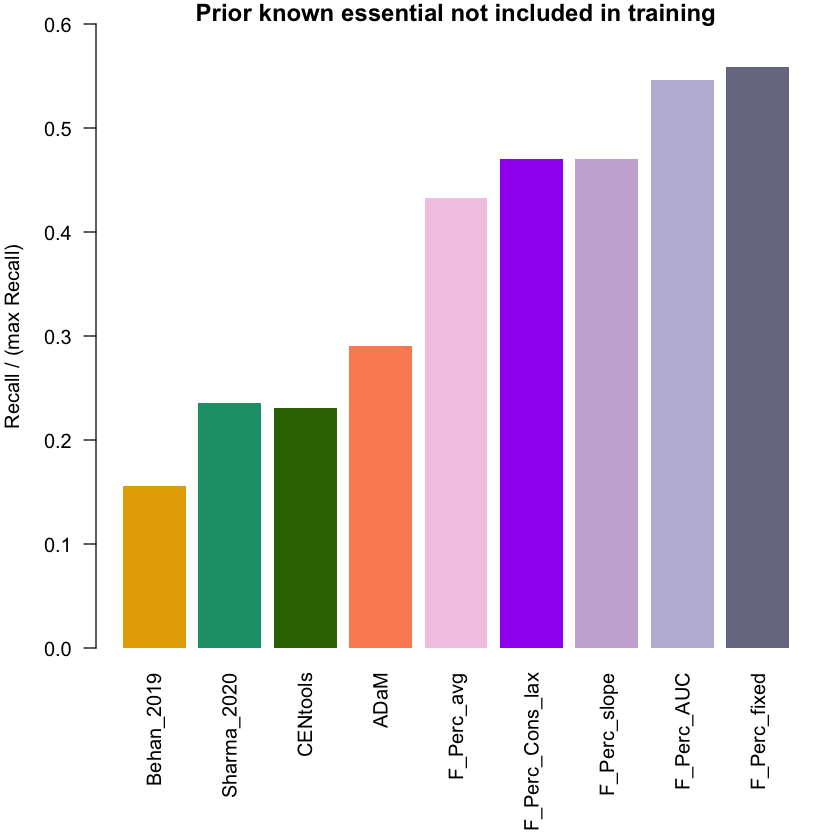

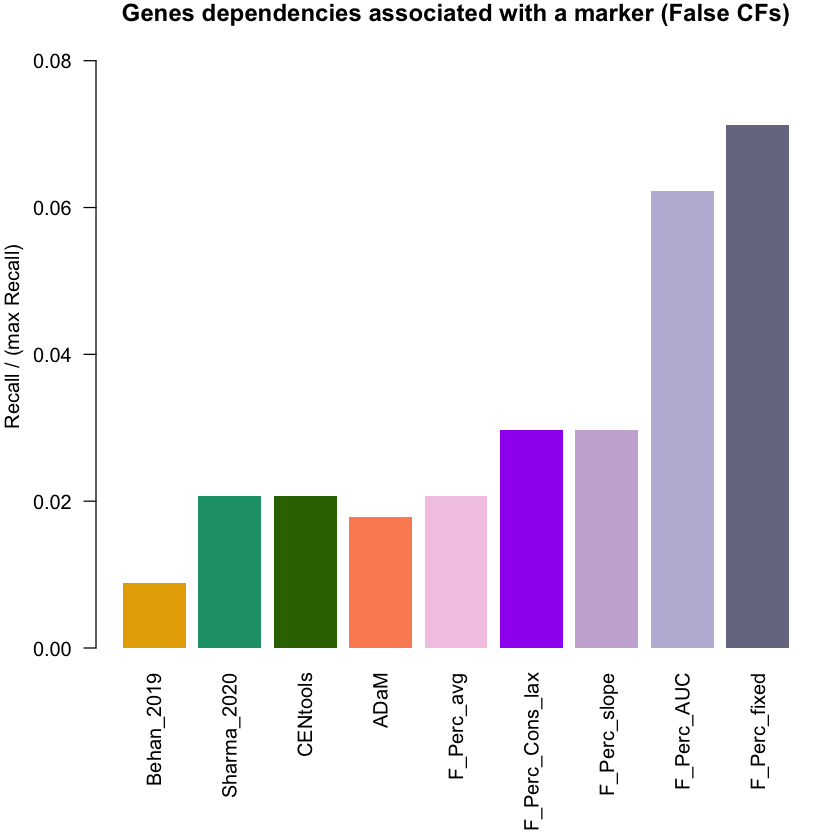

In [12]:
par(mar=c(8,4,1,1))
barplot(observed_recalls/MaxRecall,col=col[names(observed_recalls)],
        las=2,ylab='Recall / (max Recall)',ylim=c(0,0.6),
        border=NA,main = 'Prior known essential not included in training')

barplot(observed_FPs/max(baselineNEratio),col=col[names(observed_FPs)],
        las=2,ylab='Recall / (max Recall)',ylim=c(0,0.085),
        border=NA,main = 'Genes dependencies associated with a marker (False CFs)')


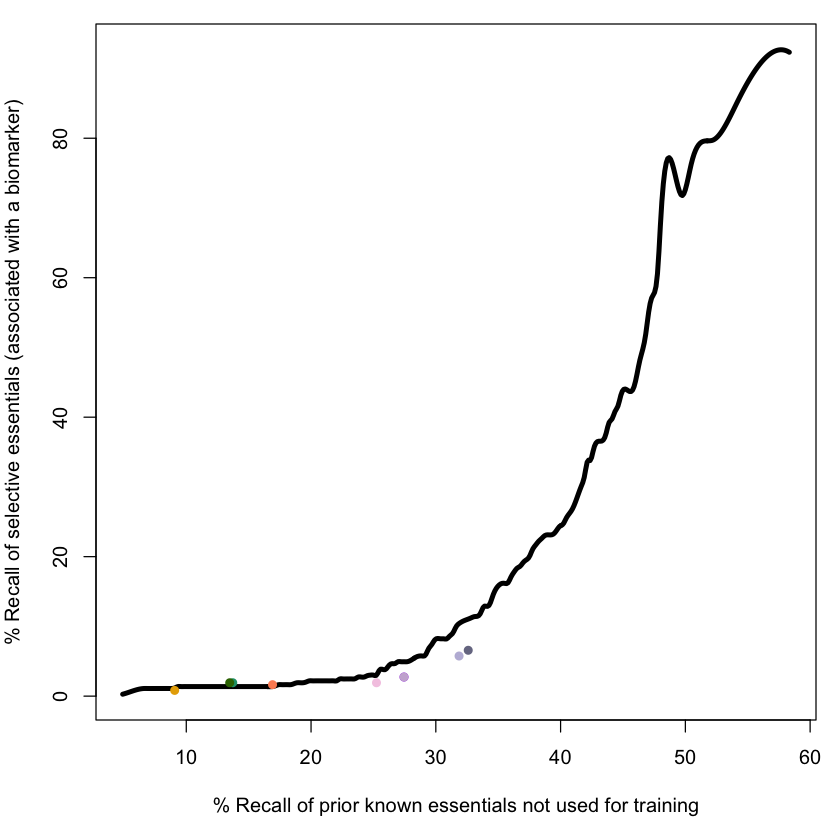

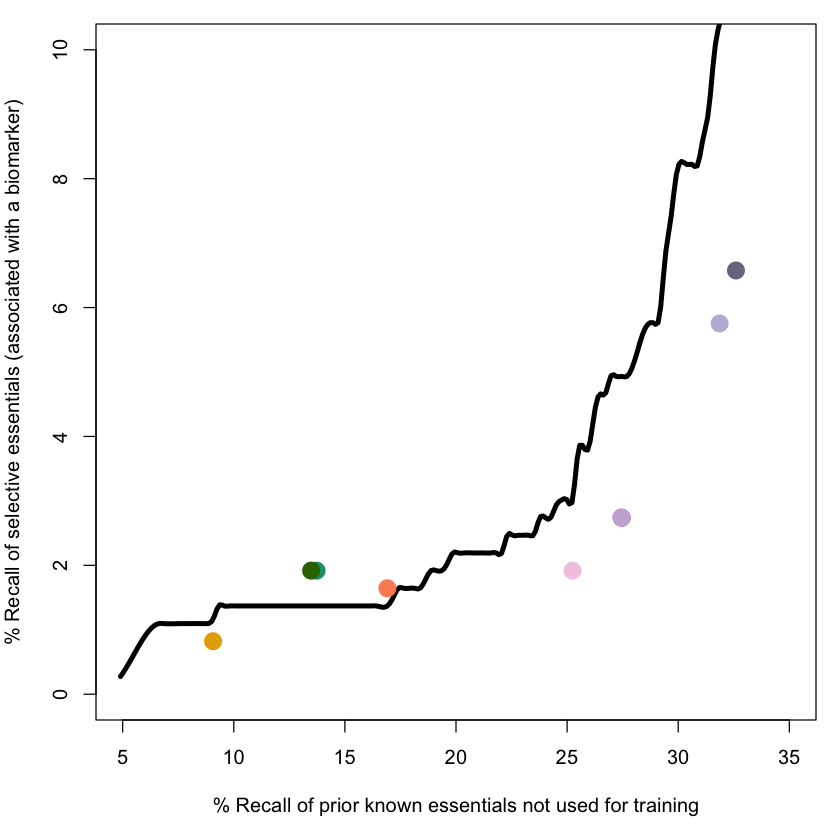

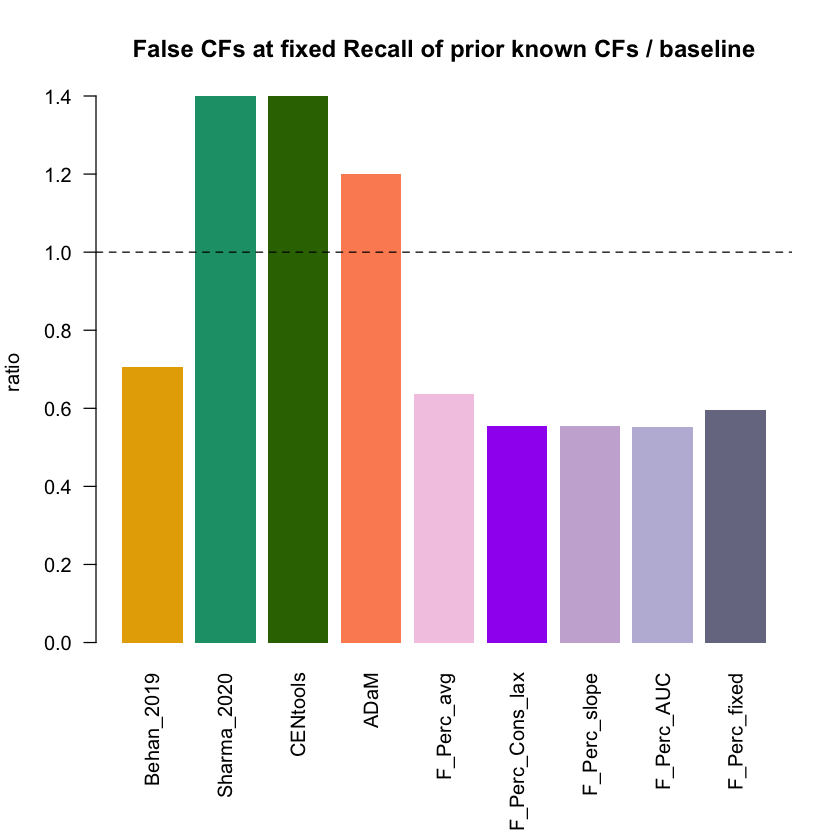

In [15]:
par(mar=c(5,4,1,1))

plot(spline(baselineRecalls,baselineNEratio),pch=16,
     xlab='% Recall of prior known essentials not used for training',
     ylab='% Recall of selective essentials (associated with a biomarker)',type='l',lwd=4)

points(observed_recalls,observed_FPs,col=col[names(observed_FPs)],pch=16)


plot(spline(baselineRecalls,baselineNEratio),pch=16,
     xlab='% Recall of prior known essentials not used for training',
     ylab='% Recall of selective essentials (associated with a biomarker)',type='l',lwd=4,
     xlim=c(5,35),ylim=c(0,10))

points(observed_recalls,observed_FPs,col=col[names(observed_FPs)],pch=16,cex=2)

s0fun<-splinefun(baselineRecalls,baselineNEratio)

par(mar=c(8,4,4,2))
barplot(observed_FPs/s0fun(observed_recalls),col=col[names(observed_FPs)],
        las=2,main='False CFs at fixed Recall of prior known CFs / baseline',
        border=NA,ylab = 'ratio')
abline(h=1,lty=2)

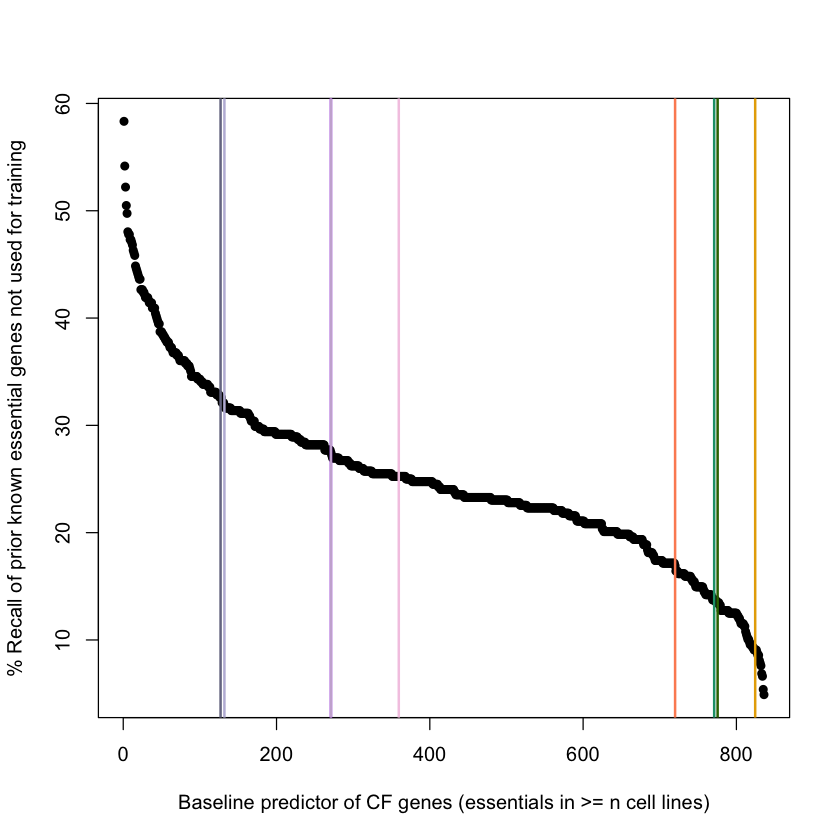

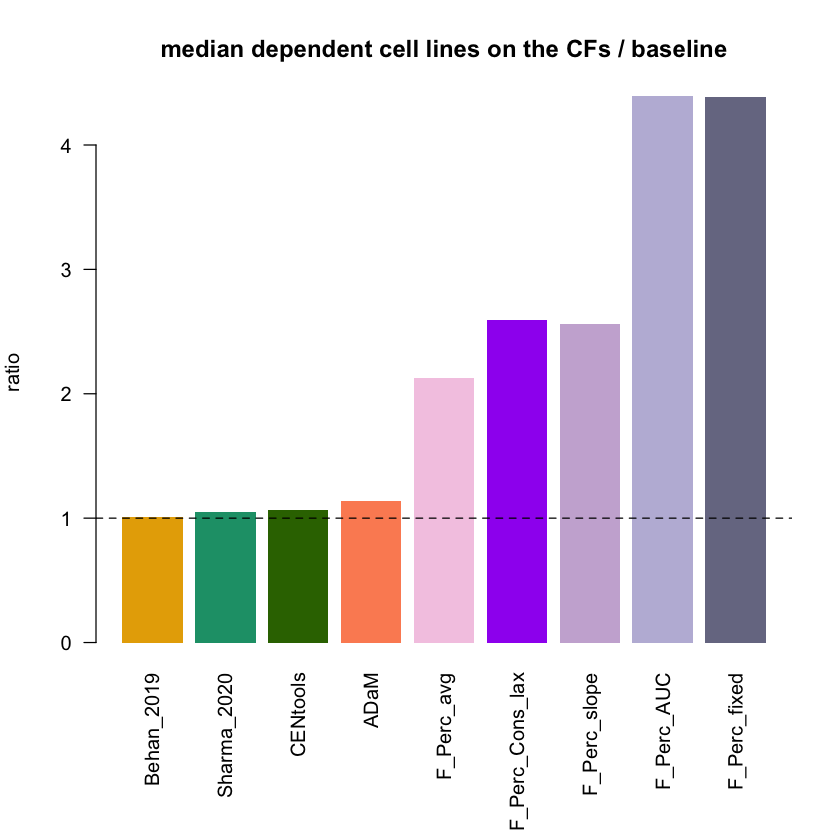

In [16]:
plot(baselineRecalls,xlab='Baseline predictor of CF genes (essentials in >= n cell lines)',
     ylab='% Recall of prior known essential genes not used for training',pch=16)

s0fun<-splinefun(baselineRecalls,1:length(baselineRecalls))

abline(v=s0fun(observed_recalls),col=col[names(observed_recalls)],lwd=2)

baseline_dep_cell_lines<-s0fun(observed_recalls)

median_n_dependent_cell_lines<-
  unlist(lapply(fCFs_sets,function(x){median(rowSums(bdep[intersect(x,rownames(bdep)),]))}))

par(mar=c(8,4,4,2))
barplot(median_n_dependent_cell_lines/baseline_dep_cell_lines,col=col[names(median_n_dependent_cell_lines)],
        las=2,main='median dependent cell lines on the CFs / baseline',
        border=NA,ylab = 'ratio')
abline(h=1,lty=2)

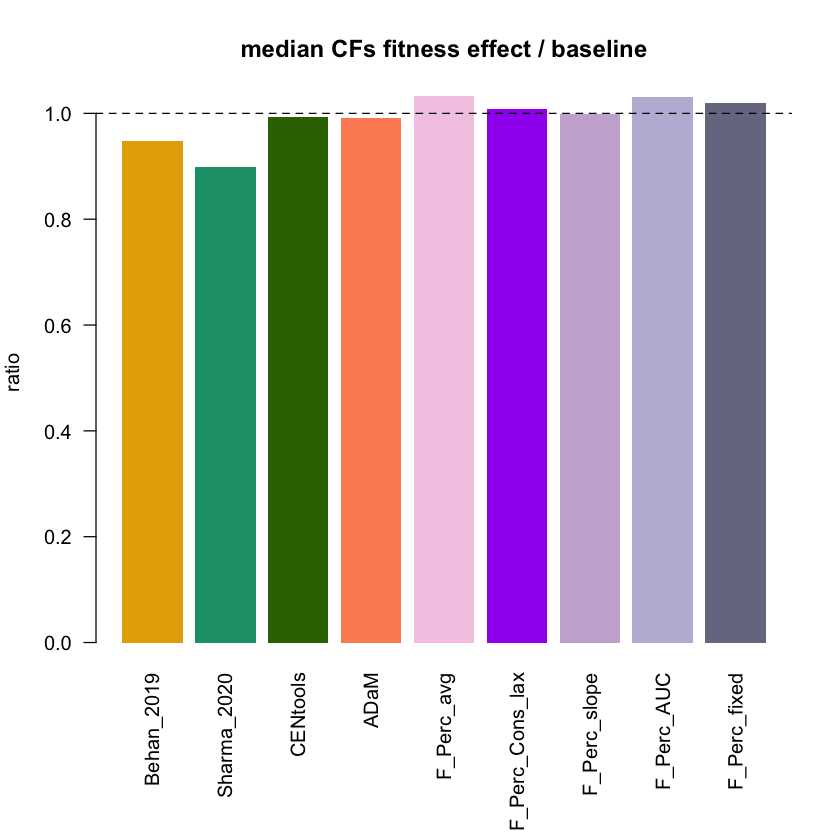

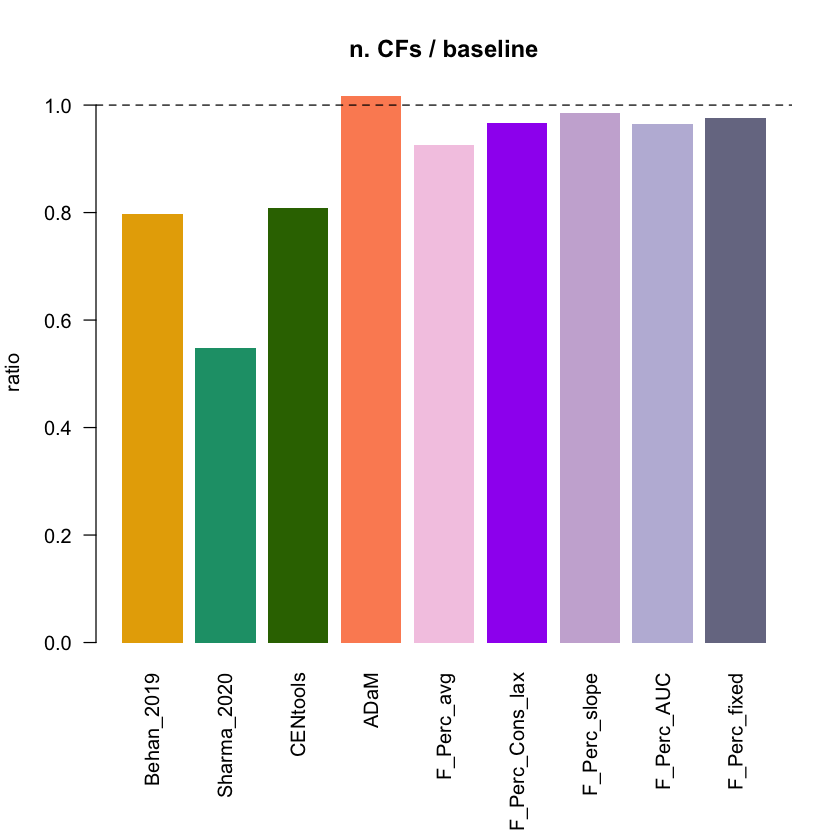

In [17]:
xx<-rownames(bdep)
xx<-setdiff(xx,c(BAGEL_essential,curated_BAGEL_essential,curated_BAGEL_nonEssential))
bdep<-bdep[xx,]
scaled_depFC<-scaled_depFC[xx,]

median_dep<-
  unlist(lapply(CFs_sets,function(x){median(apply(scaled_depFC[intersect(x,rownames(scaled_depFC)),],1,median))}))


baseline_dep<-unlist(lapply(baselineCFs[round(s0fun(observed_recalls))],
                                    function(x){median(apply(scaled_depFC[intersect(x,rownames(scaled_depFC)),],1,median))}))

par(mar=c(8,4,4,2))
barplot(median_dep/baseline_dep,col=col[names(median_dep)],
        las=2,main='median CFs fitness effect / baseline',
        border=NA,ylab = 'ratio')
abline(h=1,lty=2)


baseline_size<-unlist(lapply(baselineCFs[round(s0fun(observed_recalls))],length))

observed_sizes<-unlist(observed_sizes)

par(mar=c(8,4,4,2))
barplot(observed_sizes/baseline_size,col=col[names(observed_sizes)],
        las=2,main='n. CFs / baseline',
        border=NA,ylab = 'ratio')
abline(h=1,lty=2)

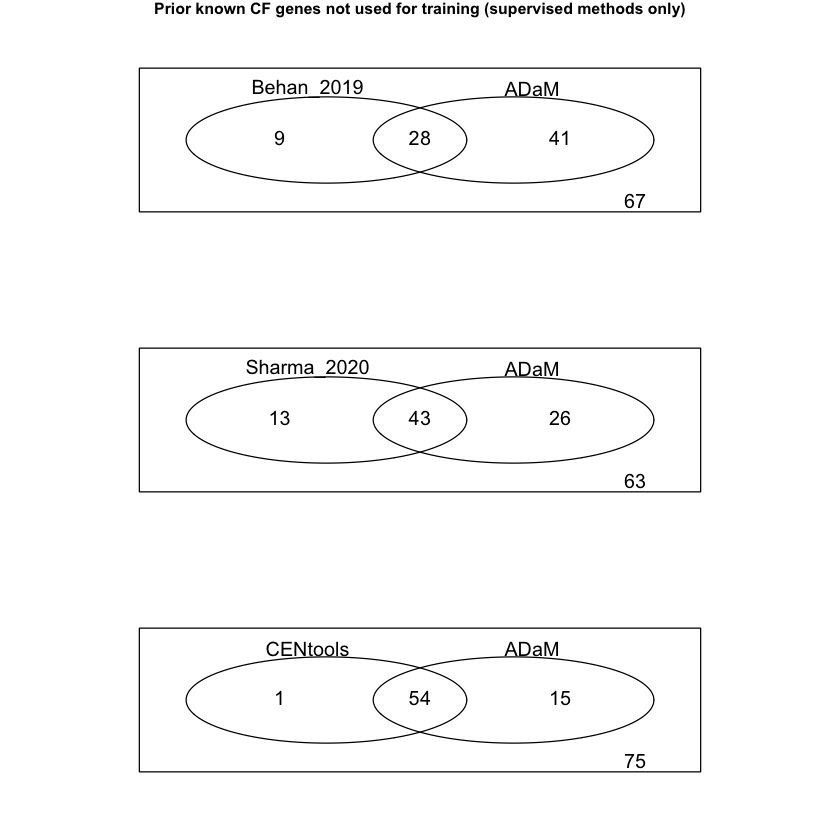

In [18]:
recalledPK<-lapply(fCFs_sets,
                   function(x){intersect(x,signatures)})
allNewHits<-unique(unlist(recalledPK))

newHitsMemb<-do.call(rbind,lapply(recalledPK,function(x){is.element(allNewHits,x)}))+0

par(mfrow=c(3,1))
vennDiagram(t(newHitsMemb[c(1,4),]),main='Prior known CF genes not used for training (supervised methods only)')
vennDiagram(t(newHitsMemb[c(2,4),]))
vennDiagram(t(newHitsMemb[c(3,4),]))